# Epsilon-greedy Q-learning for blackjack

## Packages you need

### OpenAI gym
The environment containing blackjack. 

To install: pip install gym.

### matplotlib
For visualizing how different epsilon values affect the exploration and the policy. 

To install: pip install matplotlib

### numpy
General library for handling arrays.

To install: pip install numpy

In [9]:
import gym
from gym import envs
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

Start by building the environment. Let's also set the seed to 0 to have the results be replicable. 

In [10]:
env = gym.make("Blackjack-v0")
env.seed(0);

The gym environments can be interactd with using env.step function. In blackjack 0 signifies staying and 1 taking an additional card.

Let's demonstrate the environment by playing a game. We reset the environment and get a triplet containing the value of our initial two cards, dealers face-up card and a boolean value signifying if we have an Ace. We will be ignoring the Ace in this notebook.

In [11]:
env.reset()

(18, 1, False)

We are at 18 and facing an 1 (an Ace). We should probably stay so let's call env.step(0):

In [12]:
env.step(0)

((18, 1, False), 0.0, True, {})

We are now returned a more complex object. The first element of the array is the state as described above, followed by reward (0) and a boolean signifying if the game is over. The final element contains information not provided in the blackjack environment.

So we can see that the game was a tie and we didn't win or lose anything. We could ask for the exact cards that held by both the player and the dealer:

In [13]:
print("Dealer has: {0}\n".format(env.dealer))
print("You have: {0}\n".format(env.player))

Dealer has: [1, 7]

You have: [10, 8]



Now that we have a basic understanding of how the environment works we can try to create some kind of policy to interact with it.
We have 2 actions - stay or hit - encoded as 0 and 1. We will now build a Q-table, a dictionary accessed with (our hand, dealer's hand, action) that contains what we believe to be the value of this action. We will initialize these values to 0.

In [14]:
q_table = {}
for my_hand in range(1,22):
    for dealers_hand in range(1,11):
        for action in range(0,2):
            q_table[(my_hand, dealers_hand, action)]=0

We can now run do an experiment on how the exploration rate epsilon affects the policy. The more we explore the better policy we likely end up with. However this comes at a cost - exploring different strategies in blackjack is not free!

Let's try playing TOTAL_HANDS hands of blackjack and use the first EXPLORATION_PORTION of the hands for policy exploration with the remaining ones  played using the policy we built. We will use different epsilon-values and then plot the loss over the total experiment to see how the epsilon value affects the result.

We have two hyperparameters, LEARNING_RATE and DISCOUNT_FACTOR, that can be freely set. Number of different epsilon values to explore, EPSILON_COUNT, can also be chosen.

In [15]:
TOTAL_HANDS = 100000
EXPLORATION_PORTION = 0.25
EPSILON_COUNT = 20
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99

In [16]:
best_play_value = -float('inf')
best_strategy = deepcopy(q_table)
res = []
exploration_hands = int(TOTAL_HANDS * EXPLORATION_PORTION)
playing_hands = TOTAL_HANDS-exploration_hands

# For each epsilon value run through the simulation
for epsilon in np.linspace(0,1,EPSILON_COUNT):
    total_training_reward = 0
    # Exploration portion
    # We play EXPLORATION_HANDS games and use the data to update our Q-table
    for i in range(exploration_hands):
        state = env.reset()
        # Look at the Q-values we currently have for the actions and see which one is higher
        # With probability epsilon switch to a random action
        q_values = [q_table[state[0],state[1],0],q_table[state[0],state[1],0]]
        takenaction = np.argmax(q_values)
        if(np.random.uniform()<epsilon):
            takenaction = np.random.randint(0,2)
        
        # Store the state and the action that will be taken
        q_entries = [(state[0],state[1],takenaction)]
        state = env.step(takenaction)
        
        # Keep playing until the game is over
        while(state[2]==False):
            # While the game is not over keep choosing an action and adding information to the q_entries list
            q_values = [q_table[state[0][0],state[0][1],0],q_table[state[0][0],state[0][1],0]]
            takenaction = np.argmax(q_values)
            if(np.random.uniform()<epsilon):
                takenaction = np.random.randint(0,2)
            q_entries += [(state[0][0],state[0][1],takenaction)]
            state = env.step(takenaction)

        # The game is now over and we can retrieve the reward from state[1]
        reward = state[1]
        
        # We will next traverse the recorded states in reverse order, updating our Q-table during the process
        next_state = None
        for q_entry in reversed(q_entries):
            expected_reward = reward
            if(next_state != None):
                expected_reward = q_table[next_state] * DISCOUNT_FACTOR
            previousvalue = q_table[q_entry]
            q_table[q_entry] = previousvalue + LEARNING_RATE * (expected_reward - previousvalue)
            next_state = q_entry
        total_training_reward += reward
    total_test_reward = 0
    for i in range(playing_hands):
        state = env.reset()
        q_values = [q_table[state[0],state[1],0],q_table[state[0],state[1],0]]
        takenaction = np.argmax(q_values)
        state = env.step(takenaction)
        while(state[2]==False):
            q_values = [q_table[state[0],state[1],0],q_table[state[0],state[1],0]]
            takenaction = np.argmax(q_values)
            state = env.step(takenaction)
        reward = state[1]
        total_test_reward += reward
    if(total_test_reward>best_play_value):
        best_play_value = total_test_reward
        best_strategy = deepcopy(q_table)
    res += [[epsilon,total_training_reward, total_test_reward]]

In [17]:
x = []
exploration_reward = []
playing_reward = []
total_reward = []
for r in res:
    x += [r[0]]
    exploration_reward+= [r[1]] 
    playing_reward += [r[2]]
    total_reward += [r[1]+r[2]]

We can now take a look at how much the exploration, playing and total costs were for different epsilon values:

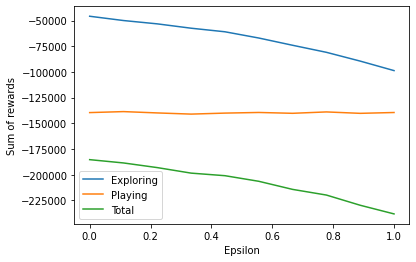

In [18]:
plt.plot(x,exploration_reward, label = "Exploring")
plt.plot(x,playing_reward, label = "Playing")
plt.plot(x, total_reward, label = "Total")
plt.xlabel("Epsilon")
plt.ylabel("Sum of rewards")
plt.legend()

As one would expect the higher the epsilon is the more expensive the exploration portion is. Interestingly it does not get offset by getting to play 3 times as many hands with the explored policy. Let's take a look at the best performing strategy to see how it looks like:

In [19]:
strategy = []
header = ["Me/Dealer"]
for i in range(1,11):
    header += [i]
strategy += [header]
for row in range(1,22):
    s = [row]
    for column in range(1,11):
        command = ["Hit"]
        if(best_strategy[(row,column,0)] > best_strategy[(row,column,1)]):
            command = ["Stay"]
        s+= command
    strategy += [s]
for strategyrow in strategy:
    print(strategyrow)

['Me/Dealer', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit']
[2, 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit']
[3, 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Hit']
[4, 'Hit', 'Stay', 'Stay', 'Stay', 'Hit', 'Stay', 'Hit', 'Hit', 'Hit', 'Stay']
[5, 'Hit', 'Hit', 'Stay', 'Stay', 'Hit', 'Hit', 'Stay', 'Hit', 'Stay', 'Hit']
[6, 'Hit', 'Hit', 'Hit', 'Hit', 'Stay', 'Stay', 'Hit', 'Hit', 'Hit', 'Hit']
[7, 'Hit', 'Stay', 'Hit', 'Stay', 'Hit', 'Stay', 'Hit', 'Hit', 'Hit', 'Stay']
[8, 'Hit', 'Stay', 'Stay', 'Hit', 'Stay', 'Hit', 'Hit', 'Stay', 'Hit', 'Hit']
[9, 'Hit', 'Hit', 'Hit', 'Stay', 'Hit', 'Hit', 'Hit', 'Stay', 'Hit', 'Hit']
[10, 'Hit', 'Hit', 'Hit', 'Hit', 'Stay', 'Hit', 'Hit', 'Hit', 'Hit', 'Stay']
[11, 'Hit', 'Hit', 'Hit', 'Stay', 'Hit', 'Stay', 'Hit', 'Hit', 'Hit', 'Stay']
[12, 'Hit', 'Hit', 'Hit', 'Hit', 'Hit', 'Stay', 'Hit', 'Stay', 'Stay', 'Hit']
[13, 'Hit', 'Stay', 'Hit', 'Hit', '

We can check how much we lost per hand with this strategy:

In [20]:
best_play_value/playing_hands

-0.18482533333333334

While this is not very good we can compare it to what we expect to the worst strategy with the lowest value for epsilon:

In [21]:
playing_reward[0]/playing_hands

-0.18611066666666667